In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision
import torchvision.transforms as transforms

import numpy as np
import sys
from PIL import Image
from scipy.stats import spearmanr as spr

In [2]:
import matplotlib.pyplot as plt
import matplotlib 
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
from captum.attr import Saliency, IntegratedGradients, LRP, GuidedBackprop, NoiseTunnel, GuidedGradCam, InputXGradient
from captum.attr import visualization as viz

In [4]:
sys.path.append("../attacks/")
from utils import get_expl, torch_to_image, load_image,  convert_relu_to_softplus, heatmap_to_image

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")

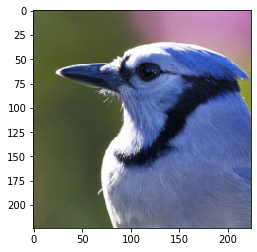

In [6]:
data_mean = np.array([0.485, 0.456, 0.406])
data_std = np.array([0.229, 0.224, 0.225])
x = load_image(data_mean, data_std, device, "../sample_imagenet/sample_0.jpg")
plt.imshow(torch_to_image(x, data_mean, data_std))

In [7]:
sigma = (torch.max(x) - torch.min(x)).item() * 0.2
sigma

0.9447309494018555

### Cascade randomization of layers

tensor(17, device='cuda:0')


/home/ubuntu/captum/captum/_utils/gradient.py:55: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  "required_grads has been set automatically." % index


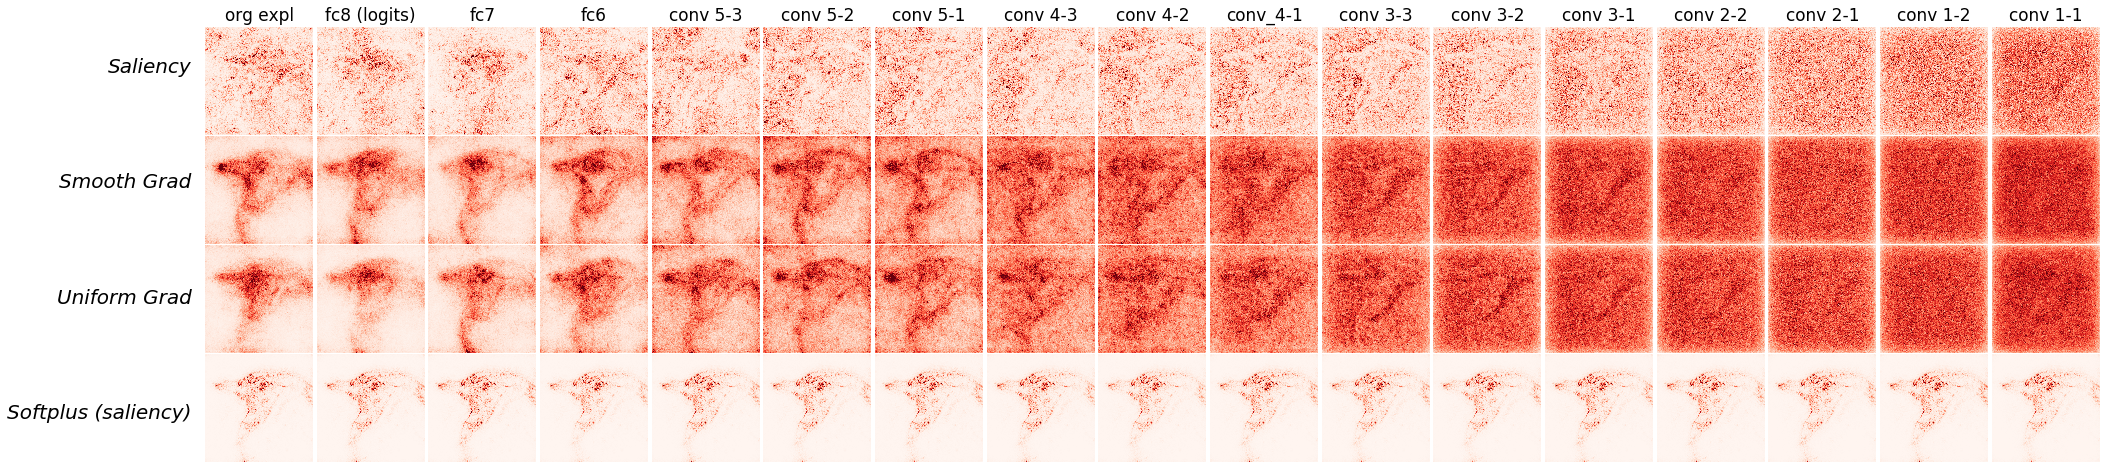

In [8]:
# cascade

layer_names = ["conv 1-1", "conv 1-2", "conv 2-1", "conv 2-2", 
              "conv 3-1", "conv 3-2", "conv 3-3",
              "conv_4-1", "conv 4-2", "conv 4-3",
              "conv 5-1", "conv 5-2", "conv 5-3",
              "fc6", "fc7", "fc8 (logits)", "org expl"]
layer_names = layer_names[::-1]

model = torchvision.models.vgg16(pretrained=True).to(device)
model = model.eval()

idx = model(x).argmax()
print(idx)


x_expl_grad = get_expl(model, x, "saliency", desired_index=idx)
x_expl_sg = get_expl(model, x, "saliency", desired_index=idx, smooth=True, sigma=sigma)
x_expl_ug = get_expl(model, x, "uniform_grad", desired_index=idx, sigma=sigma)

fig, ax = plt.subplots(4, 17, figsize=(34, 8))
viz.visualize_image_attr(np.transpose(x_expl_grad.squeeze().cpu().detach().numpy(), (1,2,0)),
                             np.transpose(x.squeeze().cpu().detach().numpy(), (1,2,0)),
                             method='heat_map',
                             cmap="Reds",
                             show_colorbar=False,
                             outlier_perc=2,
                             fig_size=(4,4), plt_fig_axis=(fig, ax[0, 0]), use_pyplot=False)

viz.visualize_image_attr(np.transpose(x_expl_sg.squeeze().cpu().detach().numpy(), (1,2,0)),
                             np.transpose(x.squeeze().cpu().detach().numpy(), (1,2,0)),
                             method='heat_map',
                             cmap="Reds",
                             show_colorbar=False,
                             outlier_perc=2,
                             fig_size=(4,4), plt_fig_axis=(fig, ax[1, 0]), use_pyplot=False)

viz.visualize_image_attr(np.transpose(x_expl_ug.squeeze().cpu().detach().numpy(), (1,2,0)),
                             np.transpose(x.squeeze().cpu().detach().numpy(), (1,2,0)),
                             method='heat_map',
                             cmap="Reds",
                             show_colorbar=False,
                             outlier_perc=2,
                             fig_size=(4,4), plt_fig_axis=(fig, ax[2, 0]), use_pyplot=False)

org_layers_to_reinit = []
# softplus_layers_to_reinit = []

for i in range(len(model.features)):
    if isinstance(model.features[i], nn.Conv2d):
        org_layers_to_reinit.append(model.features[i])
    elif isinstance(model.features[i], nn.Linear):
        org_layers_to_reinit.append(model.features[i])
    else: pass
    
for i in range(len(model.classifier)):
    if isinstance(model.classifier[i], nn.Conv2d):
        org_layers_to_reinit.append(model.classifier[i])
    elif isinstance(model.classifier[i], nn.Linear):
        org_layers_to_reinit.append(model.classifier[i])
    else: pass
org_layers_to_reinit = org_layers_to_reinit[::-1]

for i, l in enumerate(org_layers_to_reinit):
    nn.init.xavier_uniform_(l.weight)
    x_expl_grad = get_expl(model, x, "saliency", desired_index=idx)
    x_expl_sg = get_expl(model, x, "saliency", desired_index=idx, smooth=True, sigma=sigma)
    x_expl_ug = get_expl(model, x, "uniform_grad", desired_index=idx, sigma=sigma)

    viz.visualize_image_attr(np.transpose(x_expl_grad.squeeze().cpu().detach().numpy(), (1,2,0)),
                             np.transpose(x.squeeze().cpu().detach().numpy(), (1,2,0)),
                             method='heat_map',
                             cmap="Reds",
                             show_colorbar=False,
                             outlier_perc=2,
                             fig_size=(4,4), plt_fig_axis=(fig, ax[0, i+1]), use_pyplot=False)

    viz.visualize_image_attr(np.transpose(x_expl_sg.squeeze().cpu().detach().numpy(), (1,2,0)),
                             np.transpose(x.squeeze().cpu().detach().numpy(), (1,2,0)),
                             method='heat_map',
                             cmap="Reds",
                             show_colorbar=False,
                             outlier_perc=2,
                             fig_size=(4,4), plt_fig_axis=(fig, ax[1, i+1]), use_pyplot=False)
    
    viz.visualize_image_attr(np.transpose(x_expl_ug.squeeze().cpu().detach().numpy(), (1,2,0)),
                             np.transpose(x.squeeze().cpu().detach().numpy(), (1,2,0)),
                             method='heat_map',
                             cmap="Reds",
                             show_colorbar=False,
                             outlier_perc=2,
                             fig_size=(4,4), plt_fig_axis=(fig, ax[2, i+1]), use_pyplot=False)

############softplus###########################
model = torchvision.models.vgg16(pretrained=True).to(device)
model = convert_relu_to_softplus(model, beta=0.8)

x_expl_softplus = get_expl(model, x, "saliency", desired_index=idx)
viz.visualize_image_attr(np.transpose(x_expl_softplus.squeeze().cpu().detach().numpy(), (1,2,0)),
                             np.transpose(x.squeeze().cpu().detach().numpy(), (1,2,0)),
                             method='heat_map',
                             cmap="Reds",
                             show_colorbar=False,
                             outlier_perc=2,
                             fig_size=(4,4), plt_fig_axis=(fig, ax[3, 0]), use_pyplot=False)

for i, l in enumerate(org_layers_to_reinit):
    nn.init.xavier_uniform_(l.weight)
    x_expl_softplus = get_expl(model, x, "saliency", desired_index=idx)
    viz.visualize_image_attr(np.transpose(x_expl_softplus.squeeze().cpu().detach().numpy(), (1,2,0)),
                             np.transpose(x.squeeze().cpu().detach().numpy(), (1,2,0)),
                             method='heat_map',
                             cmap="Reds",
                             show_colorbar=False,
                             outlier_perc=2,
                             fig_size=(4,4), plt_fig_axis=(fig, ax[3, i+1]), use_pyplot=False)
    
    
for i in range(17):
    ax[0, i].set_title(layer_names[i], fontsize=17)
for i in range(4): 
    for j in range(17):
        ax[i,j].axis('off')
fig.text(0.12, 0.8, 'Saliency', style = 'oblique', fontsize = 20, horizontalalignment ='right')
fig.text(0.12, 0.6, 'Smooth Grad', style = 'oblique', fontsize = 20, horizontalalignment ='right')
fig.text(0.12, 0.4, 'Uniform Grad', style = 'oblique', fontsize = 20, horizontalalignment ='right')
fig.text(0.12, 0.2, 'Softplus (saliency)', style = 'oblique', fontsize = 20, horizontalalignment ='right')
plt.subplots_adjust(wspace=0.01, hspace=0.01)
plt.savefig("expls_cascade_randomized.jpg", dpi=300, bbox_inches='tight', pad_inches=0.05);

#### comparing with spr values

In [9]:
model = torchvision.models.vgg16(pretrained=True).to(device)
model = model.eval()

idx = model(x).argmax()
print(idx)


x_expl_grad_org = get_expl(model, x, "saliency", desired_index=idx).detach().cpu()
x_expl_sg_org = get_expl(model, x, "saliency", desired_index=idx, smooth=True, sigma=sigma).detach().cpu()
x_expl_ug_org = get_expl(model, x, "uniform_grad", desired_index=idx, sigma=sigma).detach().cpu()
torch.cuda.empty_cache()


org_layers_to_reinit = []
# softplus_layers_to_reinit = []

for i in range(len(model.features)):
    if isinstance(model.features[i], nn.Conv2d):
        org_layers_to_reinit.append(model.features[i])
    elif isinstance(model.features[i], nn.Linear):
        org_layers_to_reinit.append(model.features[i])
    else: pass
    
for i in range(len(model.classifier)):
    if isinstance(model.classifier[i], nn.Conv2d):
        org_layers_to_reinit.append(model.classifier[i])
    elif isinstance(model.classifier[i], nn.Linear):
        org_layers_to_reinit.append(model.classifier[i])
    else: pass
org_layers_to_reinit = org_layers_to_reinit[::-1]

# SPR VALUES
spr_grad = [1.0]
spr_smooth_grad = [1.0]
spr_uniform_grad = [1.0]
spr_softplus = [1.0]

for i, l in enumerate(org_layers_to_reinit):
    nn.init.xavier_uniform_(l.weight)
    x_expl_grad = get_expl(model, x, "saliency", desired_index=idx).detach().cpu()
    spr_grad.append(spr(x_expl_grad_org.flatten(), x_expl_grad.flatten())[0])
    del x_expl_grad
    torch.cuda.empty_cache()
    ##
    x_expl_sg = get_expl(model, x, "saliency", desired_index=idx, smooth=True, sigma=sigma).detach().cpu()
    spr_smooth_grad.append(spr(x_expl_sg_org.flatten(), x_expl_sg.flatten())[0])
    del x_expl_sg
    torch.cuda.empty_cache()
    ##
    x_expl_ug = get_expl(model, x, "uniform_grad", desired_index=idx, sigma=sigma).detach().cpu()
    spr_uniform_grad.append(spr(x_expl_ug_org.flatten(), x_expl_ug.flatten())[0])
    del x_expl_ug
    torch.cuda.empty_cache()
    

############softplus###########################
model = torchvision.models.vgg16(pretrained=True).to(device)
model = convert_relu_to_softplus(model, beta=0.8)

x_expl_softplus_org = get_expl(model, x, "saliency", desired_index=idx).detach().cpu()

for i, l in enumerate(org_layers_to_reinit):
    nn.init.xavier_uniform_(l.weight)
    x_expl_softplus = get_expl(model, x, "saliency", desired_index=idx).detach().cpu()
    spr_softplus.append(spr(x_expl_softplus_org.flatten(), x_expl_softplus.flatten())[0])
    del x_expl_softplus
    torch.cuda.empty_cache()


tensor(17, device='cuda:0')


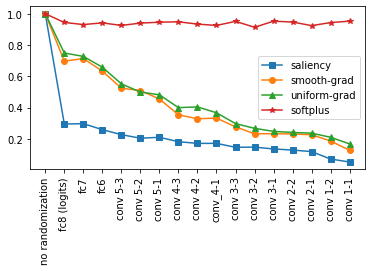

In [12]:
plt.figure(figsize=(6, 3))
plt.plot(spr_grad, label="saliency", marker="s")
plt.plot(spr_smooth_grad, label="smooth-grad", marker="o")
plt.plot(spr_uniform_grad, label="uniform-grad", marker="^")
plt.plot(spr_softplus, label="softplus", marker="*")
plt.legend()
plt.xticks(range(17), ["no randomization"] + layer_names[1:], rotation=90);
plt.savefig("spr_cascade_randomized.jpg", dpi=300, bbox_inches='tight', pad_inches=0.05);

#### comparing $\sigma$ values for smooth grad

In [9]:
model = torchvision.models.vgg16(pretrained=True).to(device)
model = model.eval()

idx = model(x).argmax()
print(idx)

sigmas = [(torch.max(x) - torch.min(x)).item() * c for c in [0.01, 0.05, 0.1, 0.2,]]
spr_rank_grad = [1.0]
spr_rank_smooth_grad = {sigma:[1.0] for sigma in sigmas}

x_expl_grad_org = get_expl(model, x, "saliency", desired_index=idx).detach().cpu()
x_expl_sg_org = {sigma: get_expl(model, x, "saliency", desired_index=idx, smooth=True, sigma=sigma).detach().cpu() 
                 for sigma in sigmas}
torch.cuda.empty_cache()

org_layers_to_reinit = []

for i in range(len(model.features)):
    if isinstance(model.features[i], nn.Conv2d):
        org_layers_to_reinit.append(model.features[i])
    elif isinstance(model.features[i], nn.Linear):
        org_layers_to_reinit.append(model.features[i])
    else: pass
    
for i in range(len(model.classifier)):
    if isinstance(model.classifier[i], nn.Conv2d):
        org_layers_to_reinit.append(model.classifier[i])
    elif isinstance(model.classifier[i], nn.Linear):
        org_layers_to_reinit.append(model.classifier[i])
    else: pass
org_layers_to_reinit = org_layers_to_reinit[::-1]

for i, l in enumerate(org_layers_to_reinit):
    nn.init.xavier_uniform_(l.weight)
    x_expl_grad = get_expl(model, x, "saliency", desired_index=idx).detach().cpu()
    spr_rank_grad.append(spr(x_expl_grad_org.flatten(), 
                             x_expl_grad.flatten())[0])
    del x_expl_grad
    torch.cuda.empty_cache()
    for sigma in sigmas:
        x_expl_sg = get_expl(model, x, "saliency", desired_index=idx, smooth=True, sigma=sigma).detach().cpu()
        spr_rank_smooth_grad[sigma].append(spr(x_expl_sg_org[sigma].flatten(),
                                              x_expl_sg.flatten())[0])
        del x_expl_sg
        torch.cuda.empty_cache()
    
    
    


tensor(17, device='cuda:0')


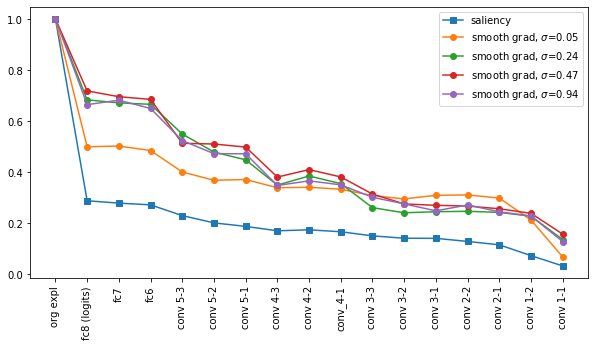

In [10]:
plt.figure(figsize=(10, 5))
plt.plot(spr_rank_grad, label="saliency", marker="s")
for s in sigmas:
    plt.plot(spr_rank_smooth_grad[s], label="smooth grad, $\sigma$={}".format(round(s, 2)), marker="o")
plt.legend()
plt.xticks(range(17), layer_names, rotation=90);
plt.savefig("spr_cascade_randomized_sg.jpg", dpi=300, bbox_inches='tight', pad_inches=0.05);

### checker board examples

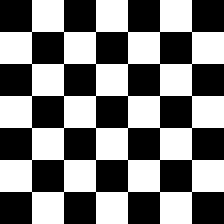

In [13]:
chess = Image.open("checkerboard.png")
chess

In [14]:
x_chess = torchvision.transforms.ToTensor()(chess).unsqueeze(0).to(device)

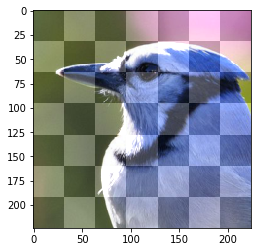

In [15]:
plt.imshow(torch_to_image(x+1*x_chess, data_mean, data_std))

In [16]:
model = torchvision.models.vgg16(pretrained=True).to(device)
model = model.eval()

In [26]:
model(x).argmax()

tensor(17, device='cuda:0')

/home/ubuntu/captum/captum/_utils/gradient.py:55: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  "required_grads has been set automatically." % index


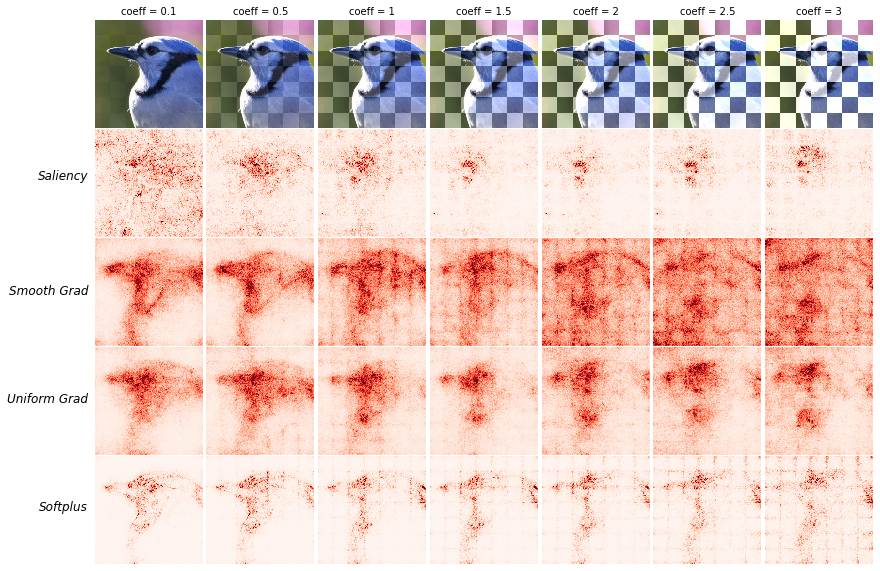

In [16]:
fig, ax = plt.subplots(5, 7, figsize=(14,10))
for i, c in enumerate([0.1, 0.5, 1, 1.5, 2, 2.5, 3]):
    ax[0, i].imshow(torch_to_image(x+c*x_chess, data_mean, data_std))
    x_expl_grad = get_expl(model, x+c*x_chess, "saliency", desired_index=idx)
    x_expl_sg = get_expl(model, x+c*x_chess, "saliency", desired_index=idx, smooth=True, sigma=sigma)
    x_expl_ug = get_expl(model, x+c*x_chess, "uniform_grad", desired_index=idx, sigma=sigma)
    viz.visualize_image_attr(np.transpose(x_expl_grad.squeeze().cpu().detach().numpy(), (1,2,0)),
                             np.transpose(x.squeeze().cpu().detach().numpy(), (1,2,0)),
                             method='heat_map',
                             cmap="Reds",
                             show_colorbar=False,
                             outlier_perc=2,
                             fig_size=(4,4), plt_fig_axis=(fig, ax[1, i]), use_pyplot=False)

    viz.visualize_image_attr(np.transpose(x_expl_sg.squeeze().cpu().detach().numpy(), (1,2,0)),
                             np.transpose(x.squeeze().cpu().detach().numpy(), (1,2,0)),
                             method='heat_map',
                             cmap="Reds",
                             show_colorbar=False,
                             outlier_perc=2,
                             fig_size=(4,4), plt_fig_axis=(fig, ax[2, i]), use_pyplot=False)
    
    viz.visualize_image_attr(np.transpose(x_expl_ug.squeeze().cpu().detach().numpy(), (1,2,0)),
                             np.transpose(x.squeeze().cpu().detach().numpy(), (1,2,0)),
                             method='heat_map',
                             cmap="Reds",
                             show_colorbar=False,
                             outlier_perc=2,
                             fig_size=(4,4), plt_fig_axis=(fig, ax[3, i]), use_pyplot=False)
########softplus###########
model = convert_relu_to_softplus(model, beta=0.8)
for i, c in enumerate([0.1, 0.5, 1, 1.5, 2, 2.5, 3]):
    x_expl_softplus = get_expl(model, x+c*x_chess, "saliency", desired_index=idx)
    viz.visualize_image_attr(np.transpose(x_expl_softplus.squeeze().cpu().detach().numpy(), (1,2,0)),
                             np.transpose(x.squeeze().cpu().detach().numpy(), (1,2,0)),
                             method='heat_map',
                             cmap="Reds",
                             show_colorbar=False,
                             outlier_perc=2,
                             fig_size=(4,4), plt_fig_axis=(fig, ax[4, i]), use_pyplot=False)
    
for i, c in enumerate([0.1, 0.5, 1, 1.5, 2, 2.5, 3]):
    ax[0, i].set_title("coeff = {}".format(c), fontsize=10)
for i in range(5):
    for j in range(7):
        ax[i,j].axis('off')
fig.text(0.12, 0.66, 'Saliency', style = 'oblique', fontsize = 12, horizontalalignment ='right')
fig.text(0.12, 0.5, 'Smooth Grad', style = 'oblique', fontsize = 12, horizontalalignment ='right')
fig.text(0.12, 0.35, 'Uniform Grad', style = 'oblique', fontsize = 12, horizontalalignment ='right')
fig.text(0.12, 0.2, 'Softplus', style = 'oblique', fontsize = 12, horizontalalignment ='right')
plt.subplots_adjust(wspace=0.01, hspace=0.01)
plt.savefig("checkerboard.jpg", dpi=300, bbox_inches='tight', pad_inches=0.05)

### adding a small object to an image

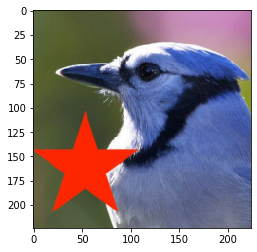

In [27]:
x_star = load_image(data_mean, data_std, device, "../sample_imagenet/sample_0_star.jpg")
plt.imshow(torch_to_image(x_star, data_mean, data_std))

In [28]:
model = torchvision.models.vgg16(pretrained=True).to(device)
model = model.eval()

In [29]:
model(x_star).argmax()

tensor(17, device='cuda:0')

/home/ubuntu/captum/captum/_utils/gradient.py:55: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  "required_grads has been set automatically." % index


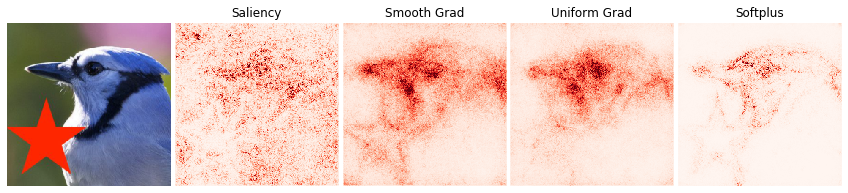

In [30]:
fig, ax = plt.subplots(1, 5, figsize=(15,3))
ax[0].imshow(torch_to_image(x_star, data_mean, data_std))

x_expl_grad = get_expl(model, x_star, "saliency", desired_index=idx).detach().cpu()
viz.visualize_image_attr(np.transpose(x_expl_grad.squeeze().numpy(), (1,2,0)),
                         np.transpose(x_star.squeeze().cpu().detach().numpy(), (1,2,0)),
                         method='heat_map',
                         cmap="Reds",
                         show_colorbar=False,
                         outlier_perc=2,
                         fig_size=(4,4), plt_fig_axis=(fig, ax[1]), use_pyplot=False)
del x_expl_grad
torch.cuda.empty_cache()

x_expl_sg = get_expl(model, x_star, "saliency", desired_index=idx, smooth=True, sigma=sigma).detach().cpu()
viz.visualize_image_attr(np.transpose(x_expl_sg.squeeze().numpy(), (1,2,0)),
                         np.transpose(x_star.squeeze().cpu().detach().numpy(), (1,2,0)),
                         method='heat_map',
                         cmap="Reds",
                         show_colorbar=False,
                         outlier_perc=2,
                         fig_size=(4,4), plt_fig_axis=(fig, ax[2]), use_pyplot=False)
del x_expl_sg
torch.cuda.empty_cache()

x_expl_ug = get_expl(model, x_star, "uniform_grad", desired_index=idx, sigma=sigma).detach().cpu()
viz.visualize_image_attr(np.transpose(x_expl_ug.squeeze().cpu().detach().numpy(), (1,2,0)),
                         np.transpose(x_star.squeeze().cpu().detach().cpu().detach().numpy(), (1,2,0)),
                         method='heat_map',
                         cmap="Reds",
                         show_colorbar=False,
                         outlier_perc=2,
                         fig_size=(4,4), plt_fig_axis=(fig, ax[3]), use_pyplot=False)
del x_expl_ug
torch.cuda.empty_cache()

##########softplus###########
model = convert_relu_to_softplus(model, beta=0.8)
x_expl_softplus = get_expl(model, x_star, "saliency", desired_index=idx).detach().cpu()
viz.visualize_image_attr(np.transpose(x_expl_softplus.squeeze().numpy(), (1,2,0)),
                         np.transpose(x_star.squeeze().cpu().detach().numpy(), (1,2,0)),
                         method='heat_map',
                         cmap="Reds",
                         show_colorbar=False,
                         outlier_perc=2,
                         fig_size=(4,4), plt_fig_axis=(fig, ax[4]), use_pyplot=False)
del x_expl_softplus
torch.cuda.empty_cache()

ax[1].set_title("Saliency")
ax[2].set_title("Smooth Grad")
ax[3].set_title("Uniform Grad")
ax[4].set_title("Softplus")
plt.subplots_adjust(wspace=0.01, hspace=0.01)
for i in range(5):
    ax[i].axis('off')
plt.savefig("added_object_expl.jpg", dpi=300, bbox_inches='tight', pad_inches=0.05)

### Grad-CAM

tensor(22)


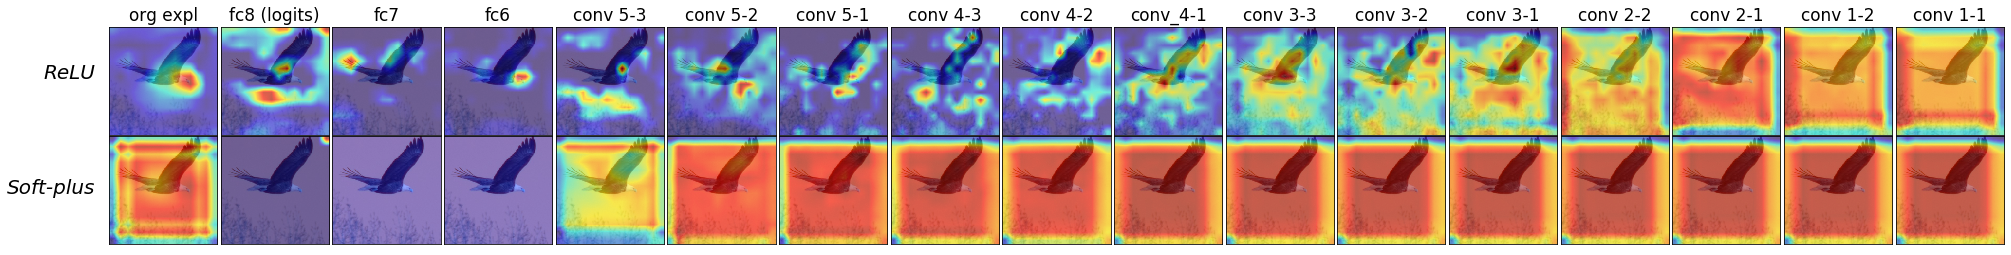

In [24]:
#grad-cam
sys.path.append("../../pytorch-grad-cam/")
from gradcam import GradCam, preprocess_image, show_cam_on_image
import cv2

#cascade
layer_names = ["conv 1-1", "conv 1-2", "conv 2-1", "conv 2-2", 
              "conv 3-1", "conv 3-2", "conv 3-3",
              "conv_4-1", "conv 4-2", "conv 4-3",
              "conv 5-1", "conv 5-2", "conv 5-3",
              "fc6", "fc7", "fc8 (logits)", "org expl"]
layer_names = layer_names[::-1]
vgg_model = torchvision.models.vgg16(pretrained=True)
vgg_model = vgg_model.eval().to(device)

grad_cam = GradCam(model=vgg_model, feature_module=vgg_model.features, \
                       target_layer_names=["28"], use_cuda=False)

idx = vgg_model(x).argmax()
print(idx)

grad_cam = GradCam(model=vgg_model, feature_module=vgg_model.features, \
                       target_layer_names=["28"], use_cuda=False)
fig, ax = plt.subplots(2, 17, figsize=(34, 4))

x_expl_relu = grad_cam(x, target_category=idx)
cam_relu = show_cam_on_image(torch_to_image(x, data_mean, data_std), x_expl_relu)

ax[0, 0].imshow(cam_relu[:, :, ::-1])

org_layers_to_reinit = []
for i in range(len(vgg_model.features)):
    if isinstance(vgg_model.features[i], nn.modules.conv.Conv2d):
        org_layers_to_reinit.append(vgg_model.features[i])
        
for i in range(len(vgg_model.classifier)):
    if isinstance(vgg_model.classifier[i], nn.modules.linear.Linear):
        org_layers_to_reinit.append(vgg_model.classifier[i])
        
org_layers_to_reinit = org_layers_to_reinit[::-1]

for i, l in enumerate(org_layers_to_reinit):
    nn.init.xavier_uniform_(l.weight)
    x_expl_relu_rand = grad_cam(x, target_category=idx)
    cam_relu_rand = show_cam_on_image(torch_to_image(x, data_mean, data_std), x_expl_relu_rand)
    ax[0, i+1].imshow(cam_relu_rand[:, :, ::-1])
################# sotfplus ######################  
vgg_model = torchvision.models.vgg16(pretrained=True)
softplus_model = softplus_net(vgg_model, data_mean, data_std, beta=0.8) 
softplus_model = softplus_model.eval().to(device)

grad_cam_softplus = GradCam(model=softplus_model, feature_module=softplus_model.layers, \
                       target_layer_names=["28"], use_cuda=False)

x_expl = grad_cam_softplus(x, target_category=idx)
cam = show_cam_on_image(torch_to_image(x, data_mean, data_std), x_expl)

ax[1, 0].imshow(cam[:, :, ::-1])

softplus_layers_to_reinit = []

for i in range(len(softplus_model.layers)):
    if isinstance(softplus_model.layers[i], nn.modules.conv.Conv2d):
        softplus_layers_to_reinit.append(softplus_model.layers[i])
        
for i in range(len(softplus_model.classifier)):
    if isinstance(softplus_model.classifier[i], nn.modules.linear.Linear):
        softplus_layers_to_reinit.append(softplus_model.classifier[i])
        
softplus_layers_to_reinit = softplus_layers_to_reinit[::-1]

for i, l in enumerate(softplus_layers_to_reinit):
    nn.init.xavier_uniform_(l.weight)
    x_expl_rand = grad_cam_softplus(x, target_category=idx)
    cam_rand = show_cam_on_image(torch_to_image(x, data_mean, data_std), x_expl_rand)
    ax[1, i+1].imshow(cam_rand[:, :, ::-1])
    
for i in range(17):
    ax[0,i].set_xticks([])
    ax[0,i].set_yticks([])
    ax[1,i].set_xticks([])
    ax[1,i].set_yticks([])
    ax[0, i].set_title(layer_names[i], fontsize=17)
fig.text(0.12, 0.7, 'ReLU', style = 'oblique', fontsize = 20, horizontalalignment ='right')
fig.text(0.12, 0.3, 'Soft-plus', style = 'oblique', fontsize = 20, horizontalalignment ='right')
plt.subplots_adjust(wspace=0.01, hspace=0.01)
plt.savefig("Grad-CAM_cascade_randomized.jpg", dpi=300, bbox_inches='tight', pad_inches=0.05);

In [ ]:
from scipy.stats import spearmanr as spr

In [ ]:
# spr(x_expl_relu.detach().flatten(), x_expl_relu_rand.detach().flatten())
spr(x_expl_relu.flatten(), x_expl_relu_rand.flatten())

In [ ]:
# spr(x_expl.detach().flatten(), x_expl_rand.detach().flatten())
spr(x_expl.flatten(), x_expl_rand.flatten())

In [ ]:
# spr(x_expl_relu.detach().flatten(), x_expl.detach().flatten())
spr(x_expl_relu.flatten(), x_expl.flatten())

In [11]:
class softplus_net(nn.Module):
    def __init__(self, model=None, data_mean=0, data_std=1, beta=None):
        super(softplus_net, self).__init__()

        # replace relus by differentiable counterpart for beta growth
        self.beta = beta
        self.activation_fn = torch.nn.ReLU(inplace=True) if beta is None else torch.nn.Softplus(beta=self.beta)

        self.layers = nn.ModuleList([])
#         self.lrp_rule_first_layer = lrp_rule_first_layer
#         self.lrp_rule_next_layers = lrp_rule_next_layers
        self.avgpool = nn.AdaptiveAvgPool2d((7, 7))
        self.classifier = model.classifier

        self.data_mean = data_mean
        self.data_std = data_std

        if model is not None:
            self.fill_layers(model)

        # remove activation function in last layer
#         self.layers[-1].activation_fn = None

        self.R = 0

    def fill_layers(self, model):
#         lrp_rule = self.lrp_rule_first_layer
        for layer in model.features:
            if type(layer) == nn.ReLU:
                self.layers.append(self.activation_fn)
            else:
                self.layers.append(layer)
        for i, layer in enumerate(model.classifier):
            if type(layer) == nn.ReLU:
                self.classifier[i] = self.activation_fn

    def forward(self, x):
        for layer in self.layers:
            x = layer.forward(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        for layer in self.classifier:
            x = layer.forward(x)

        self.R = x

        return x